In [16]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
import scipy as sp
sns.set_context('paper')
pd.set_option('display.max_columns', None)

In [17]:
with open("../Data/simu5_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)
# df_study = df_study.loc[df_study.session < 500]
# df_test = df_test.loc[df_test.session < 500]

In [18]:
df_study

,study_itemno1,study_itemno2,study_item1,study_item2,list,session
0,716,141,HOOP,BLUEJAY,1,0
1,1261,862,SEAGULL,MAN,1,0
2,1067,1402,PIKE,SUIT,1,0
3,146,707,BOLT,HIGHWAY,1,0
4,155,1140,BOULDER,PUDDLE,1,0
...,...,...,...,...,...,...
35995,397,606,CRAB,FRIEND,1,5999
35996,829,582,LIPSTICK,FLORIDA,1,5999
35997,1268,394,SENATOR,COWARD,1,5999
35998,1113,965,POSTAGE,NUT,1,5999


In [19]:
df_test

,test_itemno,test_item,correct_ans,lag,list,session
0,716,HOOP,141,5,1,0
1,736,INDIAN,1342,5,1,1
2,1217,RUM,318,1,1,2
3,1119,PREACHER,754,1,1,3
4,13,AIRPORT,327,0,1,4
...,...,...,...,...,...,...
5995,767,JUVENILE,265,5,1,5995
5996,542,EWE,602,0,1,5996
5997,1193,RING,732,2,1,5997
5998,976,OMELET,1569,0,1,5998


### Run CMR-IA

In [20]:
s_mat = np.load('../Data/wordpools/ltp_FR_similarity_matrix.npy')

In [21]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.5,
    beta_cue = 0.45,
    beta_distract = 0.1,
    gamma_fc = 0.7,
    gamma_cf = 0.5,
    s_fc = 0.1,
    s_cf = 0.1,
    c_thresh = 0.01,
    kappa = 0.08,
    lamb = 0.05,
    eta = 0.02,
    phi_s = 1.2,  # control the overall f_dif correct
    phi_d = 1.1,  # control the curve of last three, higher then upper, mediated by phi_s 
    nitems_in_accumulator = 12,
    d_ass = 0.8
)
params

{'beta_enc': 0.5,
 'beta_rec': 0.5,
 'beta_cue': 0.45,
 'beta_rec_post': 0.5,
 'beta_distract': 0.1,
 'phi_s': 1.2,
 'phi_d': 1.1,
 's_cf': 0.1,
 's_fc': 0.1,
 'kappa': 0.08,
 'eta': 0.02,
 'omega': 8,
 'alpha': 1,
 'c_thresh': 0.01,
 'c_thresh_ass': 0.5,
 'd_ass': 0.8,
 'lamb': 0.05,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 12,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 20,
 'm': 0,
 'n': 1,
 'c1': 0,
 'No_recall': None,
 'var_enc': 1,
 'bad_enc_ratio': 1,
 'gamma_fc': 0.7,
 'gamma_cf': 0.5}

In [22]:
df_simu, f_in, f_dif = cmr.run_norm_cr_multi_sess(params,df_study, df_test ,s_mat)
df_simu

CMR2 Time: 87.99211192131042


,list,session,test_itemno,s_resp,s_rt,csim
0,1,0,716,155.0,1870.0,0.716302
1,1,1,736,1454.0,2330.0,0.806805
2,1,2,1217,318.0,1400.0,0.873825
3,1,3,1119,754.0,1640.0,0.872018
4,1,4,13,327.0,1190.0,0.929485
...,...,...,...,...,...,...
5995,1,5995,767,1009.0,2130.0,0.708799
5996,1,5996,542,602.0,1930.0,0.930614
5997,1,5997,1193,755.0,1660.0,0.845602
5998,1,5998,976,266.0,2030.0,0.752279


In [23]:
df_simu = df_simu.merge(df_test,on=['session','test_itemno'])
df_simu['correct'] = df_simu.s_resp == df_simu.correct_ans
df_simu

,list_x,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,lag,list_y,correct
0,1,0,716,155.0,1870.0,0.716302,HOOP,141,5,1,False
1,1,1,736,1454.0,2330.0,0.806805,INDIAN,1342,5,1,False
2,1,2,1217,318.0,1400.0,0.873825,RUM,318,1,1,True
3,1,3,1119,754.0,1640.0,0.872018,PREACHER,754,1,1,True
4,1,4,13,327.0,1190.0,0.929485,AIRPORT,327,0,1,True
...,...,...,...,...,...,...,...,...,...,...,...
5995,1,5995,767,1009.0,2130.0,0.708799,JUVENILE,265,5,1,False
5996,1,5996,542,602.0,1930.0,0.930614,EWE,602,0,1,True
5997,1,5997,1193,755.0,1660.0,0.845602,RING,732,2,1,False
5998,1,5998,976,266.0,2030.0,0.752279,OMELET,1569,0,1,False


In [24]:
# f_in

In [25]:
sessions = df_simu.session.to_numpy()
for sess in sessions:
    df_tmp = df_study.loc[df_study.session == sess]
    tmp1 = df_tmp.study_itemno1.to_numpy()
    tmp2 = df_tmp.study_itemno2.to_numpy()
    tmp = np.concatenate((tmp1, tmp2))
    tmp = np.sort(tmp)
    testid = np.searchsorted(tmp, df_simu.test_itemno[sess].item())
    corrid = np.searchsorted(tmp, df_simu.correct_ans[sess].item())
    df_simu.loc[df_simu.session == sess, 'corr_fin']= f_dif[sess][0][corrid]
    # df_simu.loc[df_simu.session == sess, 'omean_fin'] = np.mean(np.delete(f_in[sess][0], [testid,corrid]))
    df_simu.loc[df_simu.session == sess, 'omax_fin'] = np.delete(f_dif[sess][0], corrid).max()
df_simu

,list_x,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,lag,list_y,correct,corr_fin,omax_fin
0,1,0,716,155.0,1870.0,0.716302,HOOP,141,5,1,False,-0.390344,-0.354174
1,1,1,736,1454.0,2330.0,0.806805,INDIAN,1342,5,1,False,-0.408119,-0.373943
2,1,2,1217,318.0,1400.0,0.873825,RUM,318,1,1,True,-0.292412,-0.363808
3,1,3,1119,754.0,1640.0,0.872018,PREACHER,754,1,1,True,-0.295590,-0.358743
4,1,4,13,327.0,1190.0,0.929485,AIRPORT,327,0,1,True,-0.231737,-0.418460
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1,5995,767,1009.0,2130.0,0.708799,JUVENILE,265,5,1,False,-0.418243,-0.357657
5996,1,5996,542,602.0,1930.0,0.930614,EWE,602,0,1,True,-0.218538,-0.418961
5997,1,5997,1193,755.0,1660.0,0.845602,RING,732,2,1,False,-0.343370,-0.349389
5998,1,5998,976,266.0,2030.0,0.752279,OMELET,1569,0,1,False,-0.207145,-0.398656


In [26]:
df_fin = df_simu.groupby('lag')[['corr_fin','omax_fin']].mean().reset_index()
df_fin['dif'] = df_fin['corr_fin'] - df_fin['omax_fin']
df_fin

,lag,corr_fin,omax_fin,dif
0,0,-0.235896,-0.420119,0.184222
1,1,-0.288528,-0.350355,0.061826
2,2,-0.339038,-0.358744,0.019706
3,3,-0.380529,-0.364037,-0.016492
4,4,-0.400531,-0.368480,-0.032051
5,5,-0.413457,-0.370972,-0.042485


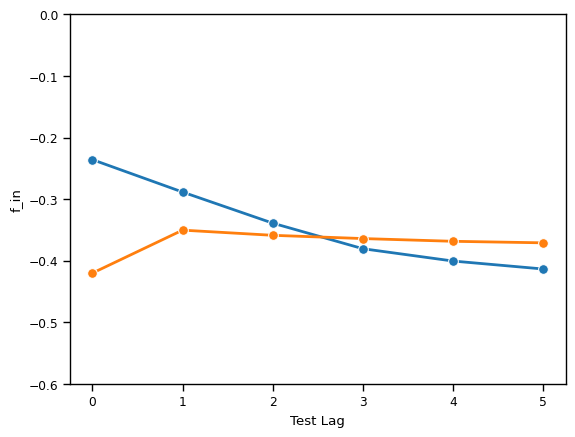

In [27]:
sns.lineplot(data=df_fin, x='lag', y='corr_fin', linewidth=2, marker='o', markersize = 7)
# sns.lineplot(data=df_fin, x='lag', y='omean_fin', linewidth=2, marker='o', markersize = 7)
sns.lineplot(data=df_fin, x='lag', y='omax_fin', linewidth=2, marker='o', markersize = 7)
plt.ylim([-0.6,0])
plt.xlabel('Test Lag')
plt.ylabel('f_in')
# plt.savefig('fig/simu3_hr.pdf')
plt.show()

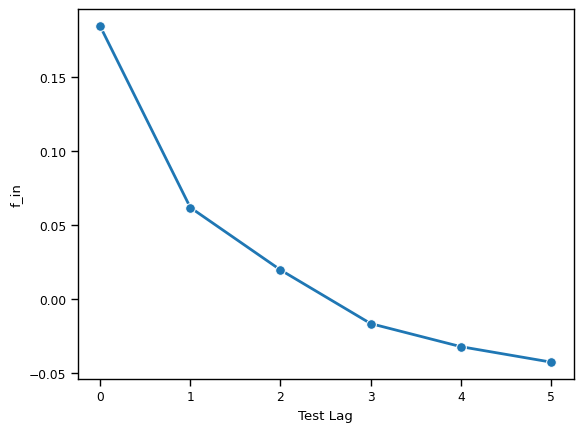

In [28]:
sns.lineplot(data=df_fin, x='lag', y='dif', linewidth=2, marker='o', markersize = 7)
# plt.ylim([0,1])
plt.xlabel('Test Lag')
plt.ylabel('f_in')
# plt.savefig('fig/simu3_hr.pdf')
plt.show()

### PLOT

In [29]:
df_laggp = df_simu.groupby(['lag']).correct.mean().to_frame(name='corr_rate').reset_index()
df_laggp

,lag,corr_rate
0,0,0.857853
1,1,0.502444
2,2,0.292000
3,3,0.225977
4,4,0.170443
5,5,0.164519


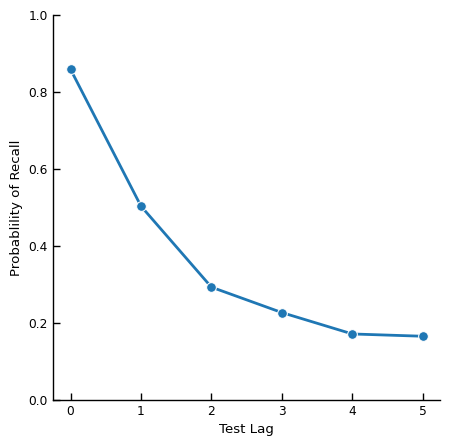

In [30]:
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_laggp, x='lag', y='corr_rate', linewidth=2, marker='o', markersize = 7)
plt.ylim([0,1])
plt.xlabel('Test Lag')
plt.ylabel('Probablility of Recall')
# plt.savefig('fig/simu5_recall.pdf')
plt.show()